In [ ]:
from typing import Any
from math import pi, sin, e
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
%matplotlib inline


# Уравнение теплопроводности и θ‑схема

Решаем начально‑краевую задачу для 1D уравнения теплопроводности на отрезке \(x\in[0,1]\):
$$
u_t = \big(k(x)\,u_x\big)_x + f(x,t),
\qquad
u(0,t)=\mu_1(t),\quad u(1,t)=\mu_2(t),\quad
u(x,0)=\phi(x).
$$

На равномерной сетке \(x_i=i h,~i=0,\dots,N,~h=\tfrac{1}{N}\) и \(t^n=n\tau\) используем **θ‑схему**:
$$
\frac{y_i^{n+1}-y_i^n}{\tau}
= \sigma\!\left(\Lambda_i y^{n+1} + f_i^{n+1}\right)+
(1-\sigma)\!\left(\Lambda_i y^{n} + f_i^{n}\right),
$$
где дискретный оператор
$$
\Lambda_i y \;=\; \frac{1}{h}\!\left(
k_{i+\frac12}\,\frac{y_{i+1}-y_i}{h}\;-\;k_{i-\frac12}\,\frac{y_i-y_{i-1}}{h}
\right),\qquad k_{i\pm\frac12}=k\!\left(x_{i\pm\frac12}\right).
$$

Граничные узлы задаём по Дирихле: \(y_0^{n+1}=\mu_1(t^{n+1}),~y_N^{n+1}=\mu_2(t^{n+1})\).
Для внутренних узлов \(i=1,\dots,N-1\) получаем трёхдиагональную СЛАУ
$$
- A_i\,y_{i-1}^{n+1} + C_i\, y_i^{n+1} - B_i\, y_{i+1}^{n+1} = F_i,
$$
с коэффициентами
$$
A_i=\sigma\frac{\tau}{h^2}\,k_{i-\frac12},\quad
B_i=\sigma\frac{\tau}{h^2}\,k_{i+\frac12},\quad
C_i=1+A_i+B_i,
$$
и правой частью
$$
F_i = y_i^n + (1-\sigma)\,\tau\,\Lambda_i y^n
+ \tau\left[\sigma f_i^{n+1} + (1-\sigma)f_i^n\right].
$$

В частном случае \(k\equiv1,\ f\equiv0,\ \mu_1=\mu_2\equiv 0,\ \phi(x)=\sin(\pi x)\)
точное решение:
$$
u(x,t)=e^{-\pi^2 t}\sin(\pi x).
$$


In [ ]:

def run_through(n: int,
                A: list[float],
                B: list[float],
                C: list[float],
                F: list[float],
                x1: float,
                x2: float,
                m1: float,
                m2: float) -> list[float]:
    """
    Метод прогонки (Thomas) для СЛАУ вида:
      -A_i y_{i-1} + C_i y_i - B_i y_{i+1} = F_i,  i=1..n-1
    Граничные условия в виде:
      y_0 = x1 * y_1 + m1,   y_n = x2 * y_{n-1} + m2.
    Для Дирихле: x1 = x2 = 0, m1 = y_0, m2 = y_n.
    Возвращает слой [y_0, y_1, ..., y_n].
    """
    alpha = [x1]
    beta  = [m1]
    for i in range(n-1):
        denom = (C[i] - A[i]*alpha[i])
        alpha.append(B[i] / denom)
        beta.append((F[i] + A[i]*beta[i]) / denom)

    y_n = (m2 + x2 * beta[-1]) / (1.0 - x2 * alpha[-1])

    y = [0.0]*(n+1)
    y[-1] = y_n
    for i in range(n-1, -1, -1):
        y[i] = alpha[i]*y[i+1] + beta[i]
    return y


In [ ]:

def F(x: float = 0.0, t: float = 0.0) -> float:
    return 0.0

def k(x: float = 0.0) -> float:
    return 1.0

def fi(x: float = 0.0) -> float:
    return sin(pi * x)

def m1(t: float = 0.0) -> float:
    return 0.0

def m2(t: float = 0.0) -> float:
    return 0.0

def analit_reshen(x: float, t: float) -> float:
    return e**(-(pi**2) * t) * sin(pi * x)


In [ ]:

from typing import Callable

def raznost(n: int,
            F_fun: Callable[[float,float], float],
            k_fun: Callable[[float], float],
            fi_fun: Callable[[float], float],
            m1_fun: Callable[[float], float],
            m2_fun: Callable[[float], float],
            sigma: float,
            h: float,
            tau: float,
            T_max: float) -> list[list[float]]:
    steps = int(T_max / tau + 1e-12) + 1
    y = [[0.0]*(n+1) for _ in range(steps)]

    # t=0
    y[0][0] = m1_fun(0.0)
    y[0][-1] = m2_fun(0.0)
    for i in range(1, n):
        y[0][i] = fi_fun(h*i)

    # k at half nodes
    k_half = [k_fun(h*(i+0.5)) for i in range(n)]

    r = sigma * tau / (h*h)
    A = [r * k_half[i-1] for i in range(1, n)]
    B = [r * k_half[i]   for i in range(1, n)]
    C = [1.0 + A[i-1] + B[i-1] for i in range(1, n)]

    for step in range(1, steps):
        t_n  = (step-1)*tau
        t_np = step*tau

        rhs = [0.0]*(n-1)
        for i in range(1, n):
            dy_right = (y[step-1][i+1] - y[step-1][i]) / h
            dy_left  = (y[step-1][i]   - y[step-1][i-1]) / h
            Lam = (k_half[i] * dy_right - k_half[i-1] * dy_left) / h
            x_i = h*i
            rhs[i-1] = y[step-1][i] + (1.0 - sigma) * tau * Lam \
                       + tau*(sigma*F_fun(x_i, t_np) + (1.0 - sigma)*F_fun(x_i, t_n))

        layer = run_through(n, A, B, C, rhs, 0.0, 0.0, m1_fun(t_np), m2_fun(t_np))
        y[step] = layer
    return y



## Сравнение с точным решением

Для \(\phi(x)=\sin(\pi x),~\mu_1=\mu_2\equiv 0,~k\equiv1,~f\equiv0\) решением является
\(u(x,t)=e^{-\pi^2 t}\sin(\pi x)\). Ниже строим профили в моменты \(t=0.5,~1.0,~1.5\)
и печатаем максимальную ошибку за весь интервал времени.


In [ ]:

def run_and_plot(sigma=0.5, h=0.01, tau=0.01, T_max=1.5, show_times=(0.5, 1.0, 1.5)):
    n = int(round(1.0/h))
    y = raznost(n, F, k, fi, m1, m2, sigma, h, tau, T_max)
    steps = int(T_max / tau + 1e-12) + 1
    xs = [i*h for i in range(n+1)]

    max_err = 0.0
    for s in range(steps):
        t_s = s*tau
        errs = [abs(y[s][i] - analit_reshen(xs[i], t_s)) for i in range(n+1)]
        max_err = max(max_err, max(errs))

    print(f"sigma = {sigma},  h = {h},  tau = {tau},  T_max = {T_max}")
    print("max error over 0..T_max:", max_err)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()
    for tt in show_times:
        s = int(round(tt/tau))
        ax.plot(xs, y[s], label=f"t={tt:g}")
        ax.plot(xs, [analit_reshen(x, tt) for x in xs], "--", linewidth=1)
    ax.grid(True); ax.set_xlabel("x"); ax.set_ylabel("u(x,t)")
    ax.set_title(f"Профили решения (σ={sigma})")
    ax.legend()
    plt.show()


In [ ]:
# sigma = 0.0
# h = 0.01
# tay = 0.00005
# T_max = 3
# my_max = 0
# n = 100

sigma = 0.0,  h = 0.01,  tau = 0.0005,  T_max = 3
max error over 0..T_max: 5.290993714974241e+304


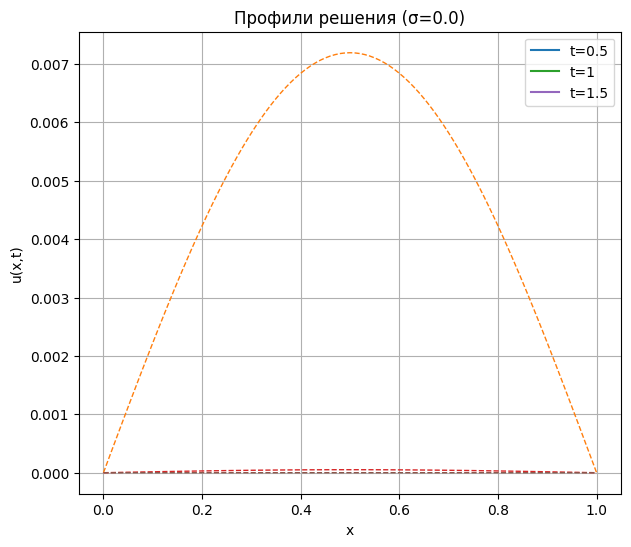

In [ ]:
run_and_plot(sigma=0.0, h=0.01, tau=0.0005, T_max=3)

sigma = 0.25,  h = 0.01,  tau = 0.005,  T_max = 1.5
max error over 0..T_max: 6.852343541819088e+123


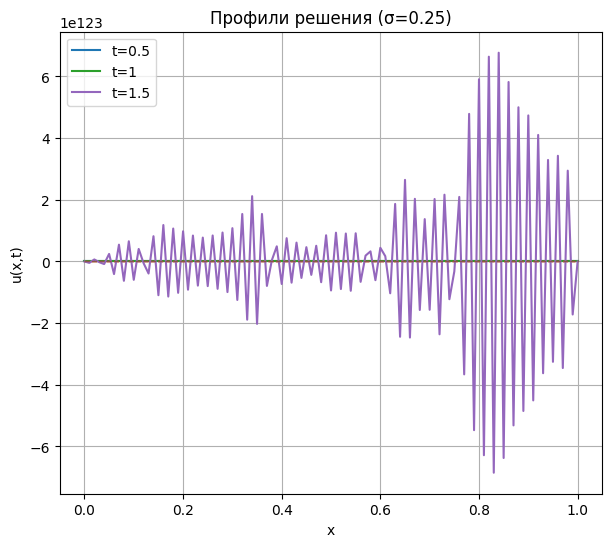

In [ ]:
run_and_plot(sigma=0.25, h=0.01, tau=0.005, T_max=1.5)

sigma = 0.4,  h = 0.01,  tau = 0.01,  T_max = 1.5
max error over 0..T_max: 9329436960.077473


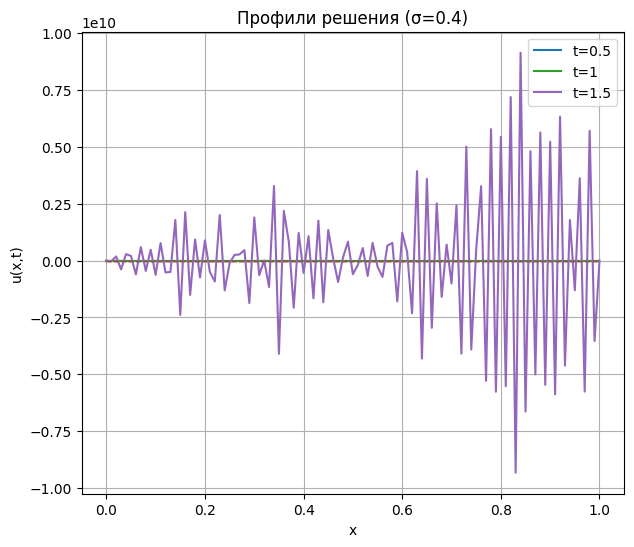

In [ ]:
run_and_plot(sigma=0.4, h=0.01, tau=0.01, T_max=1.5)

sigma = 0.5,  h = 0.01,  tau = 0.01,  T_max = 1.5
max error over 0..T_max: 0.00026861082377710455


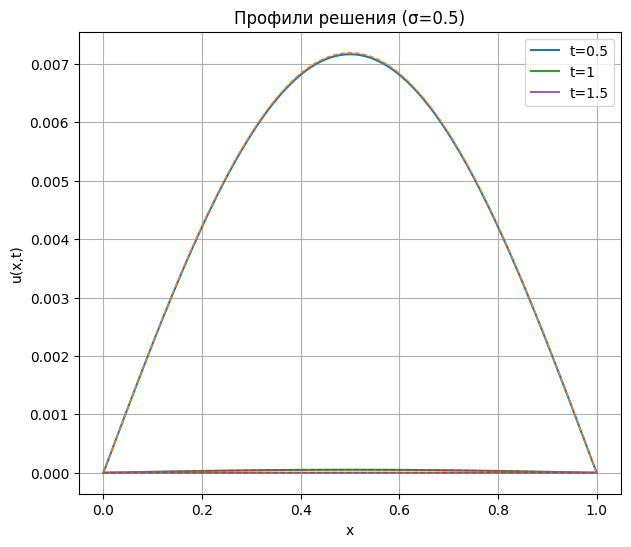

In [ ]:
run_and_plot(sigma=0.5, h=0.01, tau=0.01, T_max=1.5)

sigma = 0.75,  h = 0.01,  tau = 0.01,  T_max = 1.5
max error over 0..T_max: 0.008708868944834358


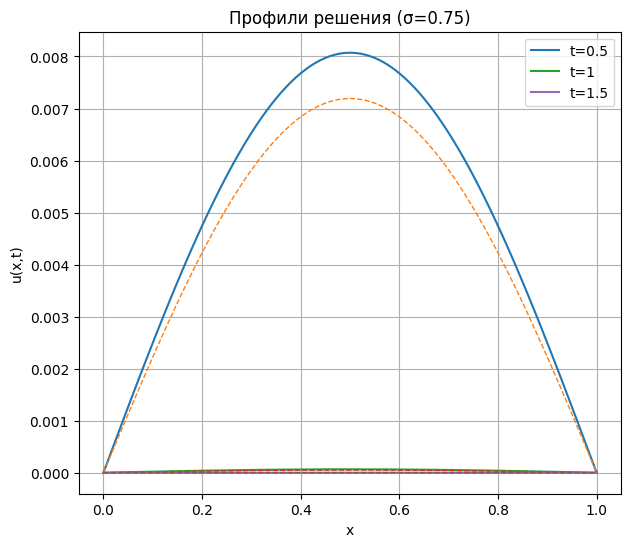

In [ ]:
run_and_plot(sigma=0.75, h=0.01, tau=0.01, T_max=1.5)

sigma = 0.9,  h = 0.01,  tau = 0.01,  T_max = 1.5
max error over 0..T_max: 0.013988488334089222


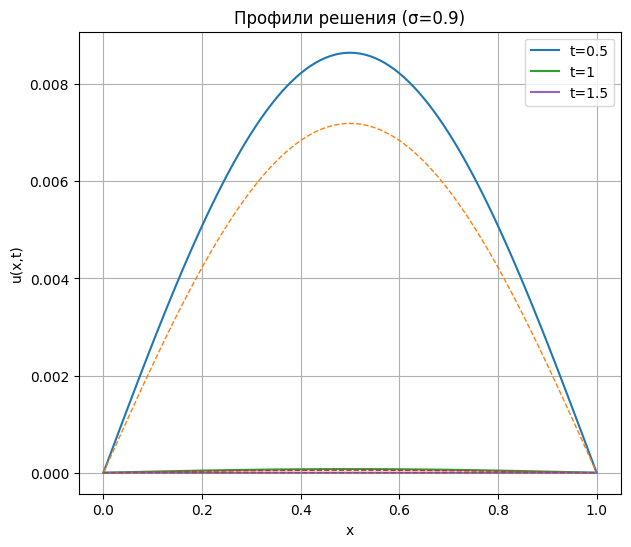

In [ ]:
run_and_plot(sigma=0.9, h=0.01, tau=0.01, T_max=1.5)

sigma = 1.0,  h = 0.01,  tau = 0.01,  T_max = 1.5
max error over 0..T_max: 0.01746450080623796


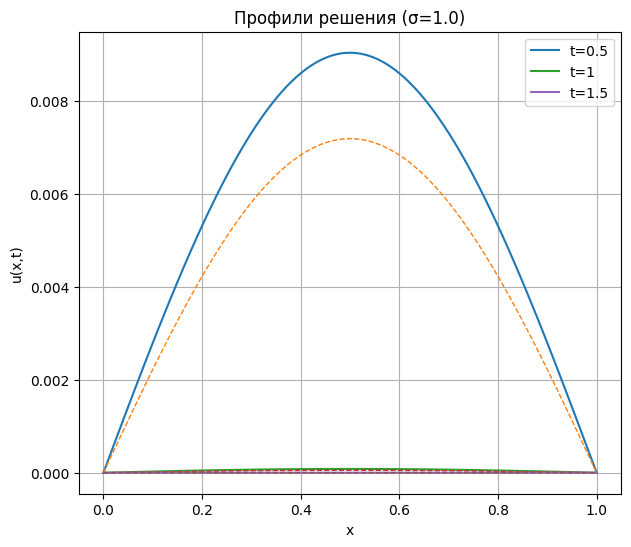

In [ ]:
run_and_plot(sigma=1.0, h=0.01, tau=0.01, T_max=1.5)

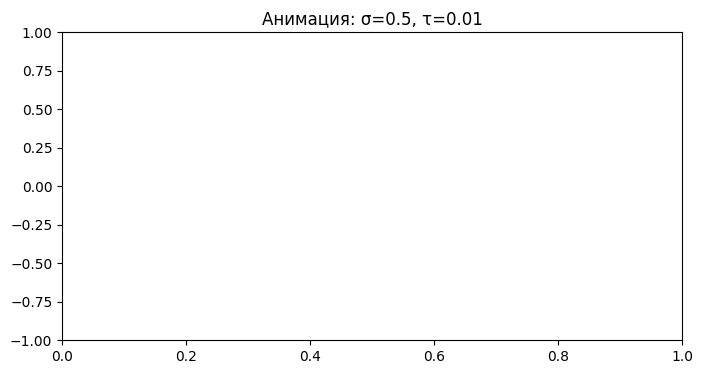

In [ ]:

sigma = 0.5; h = 0.01; tau = 0.01; T_max = 2.0
n = int(round(1.0/h))
xs = [i*h for i in range(n+1)]
Y = raznost(n, F, k, fi, m1, m2, sigma, h, tau, T_max)

fig = plt.figure(figsize=(8, 4))
ax = plt.axes(xlim=(0,1), ylim=(-1,1))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(frame):
    line.set_data(xs, Y[frame])
    return line,

frames = int(T_max/tau)+1
anim = FuncAnimation(fig, animate, init_func=init, frames=frames, interval=50, blit=True)
plt.title(f"Анимация: σ={sigma}, τ={tau}")
plt.show()
